In [3]:
import glob
import joblib
import numpy as np
import pandas as pd
import PIL
import pydicom
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import concurrent.futures
import itertools
import cv2
from random import sample
from sklearn.cluster import KMeans

# Constants

In [17]:
DATA_DIR = '../data'

TRAIN_DIR = DATA_DIR + '/stage_2_train_images'
TEST_DIR = DATA_DIR + '/stage_2_test_images'

train_files_list = os.listdir(TRAIN_DIR)
test_files_list = os.listdir(TEST_DIR)

RESIZED_WIDTH, RESIZED_HEIGHT = 299, 299

train_meta_data = pd.read_csv(DATA_DIR + '/stage_2_train_ordered.csv')
test_meta_data = pd.read_csv(DATA_DIR + '/stage_2_test_ordered.csv')

TRAIN_OUTPUT_DIR = DATA_DIR + '/numpy_array/stage_2_train_images_299_roi_interpolated/'
TEST_OUTPUT_DIR = DATA_DIR + '/numpy_array/stage_2_test_images_299_roi_interpolated/'

In [6]:
len(train_files_list)

752803

In [7]:
len(test_files_list)

121232

In [8]:
def getROI(img):
    
    if np.sum(img) == 0:
        return img
    
    original_area = img.shape[0] * img.shape[1]
    
    one_channel_img = np.mean(img, axis=2)
    
    #ts = np.quantile(one_channel_img.flatten(), 0.50, axis=0)
    
    ts = np.mean(one_channel_img)
    
    #mask = img == 255
    mask = one_channel_img > ts
    
    thresh = ((1 - mask) * 255).astype(np.uint8)
    
    cnts = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[-2]
    cnts = sorted(cnts, key=cv2.contourArea)
    
    if len(cnts) == 1:
        return img
        
    x,y,w,h = cv2.boundingRect(cnts[-2])
    y2 = y+h
    x2 = x+w
    
    new_area = (y2-y) * (x2-x)
    
    # Ignore if new area was smaller than one third of original image
    if new_area < original_area / 4:
        new_img = img
    else:
        new_img = img[y:y2, x:x2, :]
        
    return new_img

In [9]:
#def getROI(img):
#    # Flat image and fit cluster
#    original_shape = img.shape
#    kmeans = KMeans(n_clusters=2, random_state=0).fit(img.flatten().reshape(-1, 1))
#    mask = kmeans.predict(img.reshape(-1, 1))
#    mask = mask.reshape(original_shape)
#    
#    thresh = ((1 - mask) * 255).astype(np.uint8)
#    
#    cnts = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[-2]
#    cnts = sorted(cnts, key=cv2.contourArea)
#    
#    x,y,w,h = cv2.boundingRect(cnts[-2])
#    return img[y:y+h, x:x+w]

In [10]:
def makeSquared(img):
    h, w = img.shape[0], img.shape[1]
    
    if h == w:
        return img
    
    padding = abs(h - w) // 2
    
    if h < w:
        top =  padding
        bottom = padding
        left = 0
        right = 0
    else:
        top = 0
        bottom = 0
        left = padding
        right = padding
        
    color = [0, 0, 0]
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

    return img

In [11]:
def getPreviousImgID(img_id, metadata):
    actual_index = metadata.index[metadata['SOP Instance UID'] == img_id].tolist()[0]
    actual_order = metadata[metadata['SOP Instance UID'] == img_id].Order.values[0]
    if actual_order == 1:
        return img_id
    else:
        previous_id = metadata.iloc[max(0, actual_index - 1)]['SOP Instance UID']
        return previous_id
    
def getNextImgId(img_id, metadata):
    actual_index = metadata.index[metadata['SOP Instance UID'] == img_id].tolist()[0]

    next_id = metadata.iloc[min(len(metadata)-1, actual_index + 1)]['SOP Instance UID']
    next_order = metadata[metadata['SOP Instance UID'] == next_id].Order.values[0]
    
    if next_order == 1:
        return img_id
    else:
        return next_id

In [12]:
def get_id(img_path):
    img_dicom = pydicom.read_file(img_path)
    return str(img_dicom.SOPInstanceUID)

def window_image_linear(img, window_center, window_width, intercept, slope):
    img = img * slope + intercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img[img < img_min] = img_min
    img[img > img_max] = img_max
    
    return img 

def window_image_sigmoid(img, window_center, window_width, intercept, slope):
    img = img * slope + intercept
    W = (2* np.log(254))/window_width
    b = ((-2*window_center)* np.log(254))/window_width
    img = 255/(1+np.exp(-(W*img+b)))
    return img 

def resize2(img, new_w, new_h):
    img = PIL.Image.fromarray(img.astype(np.int8), mode="L")
    return img.resize((new_w, new_h), resample=PIL.Image.BICUBIC)

def resize(img, new_w, new_h):
    img = cv2.resize(img, (new_w, new_h))
    return img

def normalize_minmax(img):
    mi, ma = img.min(), img.max()
    return (img - mi) / (ma - mi)

def prepare_image(img_path, wc, ww, function = 'linear'):
    img_dicom = pydicom.read_file(img_path)
    
    img_dicom = img_dicom.pixel_array

    if function == 'linear':
        img = window_image_linear(img_dicom, wc, ww, -1024, 1)
        img = normalize_minmax(img) * 255
    elif function == 'sigmoid':
        img = window_image_sigmoid(img_dicom, wc, ww, -1024, 1)
    else:
        print('Function should be "linear" or "sigmoid"')
    
    return img

def get_all_image_types(img_path, function = 'linear', ROI=False):
                  
    img_tissue = prepare_image(img_path, 40, 40, function)
                  
    img_brain = prepare_image(img_path, 40, 80, function)
                  
    #img_blood = prepare_image(img_path, 60, 40)
                  
    img_subdural = prepare_image(img_path, 50, 130, function)
                  
    img = np.dstack((img_tissue, img_brain, img_subdural))
    if ROI:
        img = getROI(img)
        img = makeSquared(img)
    
    img = resize(img, RESIZED_WIDTH, RESIZED_HEIGHT)
    
    img = np.asarray( img, dtype="uint8" )
                  
    return img

def interpolate(img_id, metadata, path, function = 'linear'):    
    #Get current img
    current_img = get_all_image_types(path + '/' + img_id + '.dcm', function, True)
    current_img = np.mean(current_img, axis = 2)
    
    #Get Previous img
    prev_id = getPreviousImgID(img_id, metadata)
    prev_img = get_all_image_types(path + '/' + prev_id + '.dcm', function, True)
    prev_img = np.mean(prev_img, axis = 2)
    
    #Get Next img
    next_id = getNextImgId(img_id, metadata)
    next_img = get_all_image_types(path + '/' + next_id + '.dcm', function, True)
    next_img = np.mean(next_img, axis = 2)
    
    interpolated = np.dstack((prev_img, current_img, next_img)).astype("uint8")
    return interpolated
    
def save_numpy_array(array, output, filename):
    np.save(output+filename, array)
    
def train_pre_processer(file, function = 'linear'):
    try:
        img_path = os.path.join(TRAIN_DIR, file)
        file_id = get_id(img_path)
#         array = get_all_image_types(img_path, function, True)
        array = interpolate(file_id, train_meta_data, TRAIN_DIR, function)
        save_numpy_array(array, TRAIN_OUTPUT_DIR, file_id)
    except:
        print('Failed with img {}'.format(file))
    
def test_pre_processer(file, function = 'linear'):
    try:
        img_path = os.path.join(TEST_DIR, file)
        file_id = get_id(img_path)
#         array = get_all_image_types(img_path, function, True)
        array = interpolate(file_id, test_meta_data, TEST_DIR, function)
        save_numpy_array(array, TEST_OUTPUT_DIR, file_id)
    except:
        print('Failed with img {}'.format(file))
        
def PreprocessImages(folder, files_list):
    
    if folder == 'test':    
        with concurrent.futures.ProcessPoolExecutor() as executor:      
            for result in executor.map(test_pre_processer, files_list):
                pass
    elif folder == 'train':   
        with concurrent.futures.ProcessPoolExecutor() as executor:      
            for result in executor.map(train_pre_processer, files_list):
                pass
    else:
        print('Choose "train" or "test"')

# Test image function

In [13]:
files = sample(train_files_list, 10)

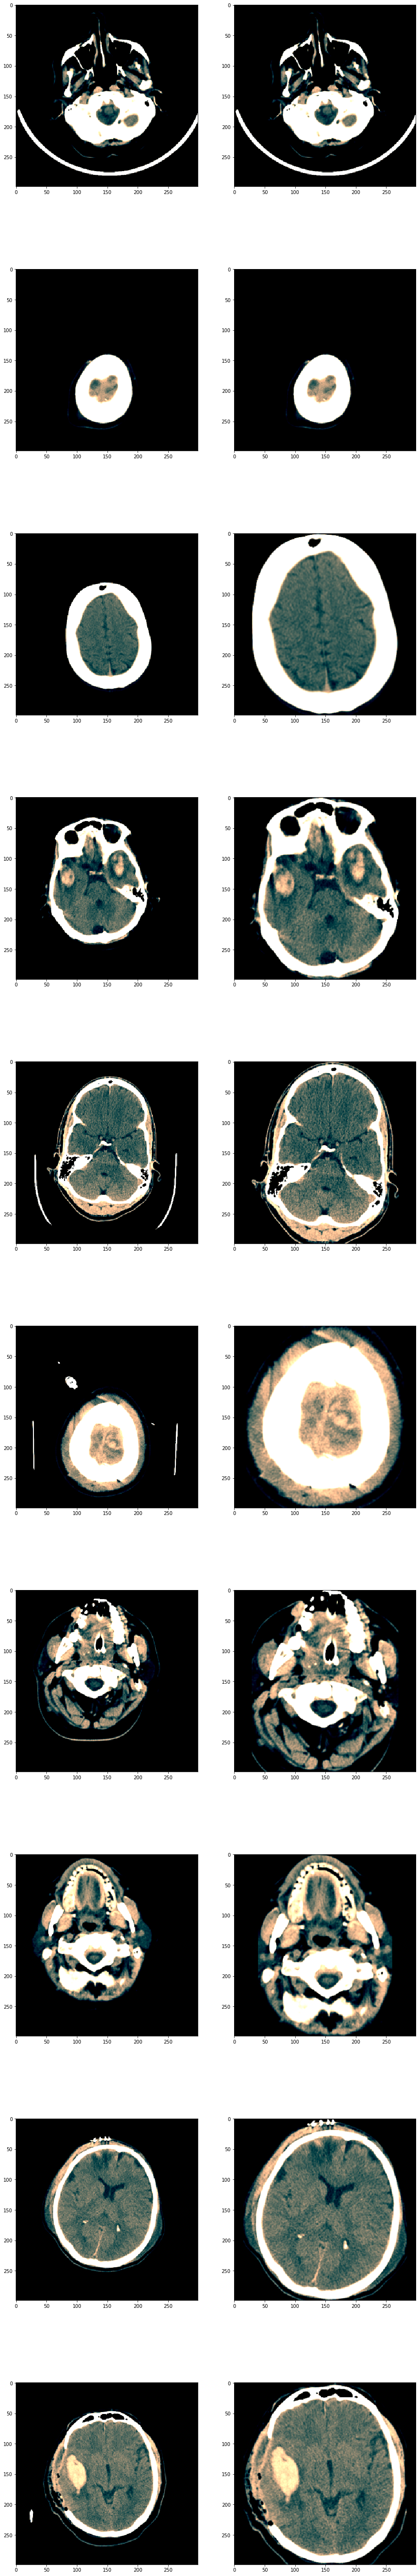

In [14]:
fig, axes = plt.subplots(nrows=len(files), ncols=2, figsize=(15, 100))

for i, f in enumerate(files):
    
    img = get_all_image_types(TRAIN_DIR + '/' + f, 'linear', ROI=False)
    img_roi = get_all_image_types(TRAIN_DIR + '/' + f, 'linear', ROI=True)
    
    axes[i, 0].imshow(img, cmap='gray')
    axes[i, 1].imshow(img_roi, cmap='gray')
    
#fig.show()

# Save images

In [16]:
PreprocessImages('train', train_files_list)

/srv/app/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/srv/app/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/srv/app/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/srv/app/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/srv/app/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/srv/app/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/srv/app/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


/srv/app/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/srv/app/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/srv/app/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/srv/app/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/srv/app/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/srv/app/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/srv/app/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  fr

Failed with img ID_dfcb69305.dcm
Failed with img ID_6431af929.dcm
Failed with img ID_5005bcb25.dcm


In [18]:
len(os.listdir(TRAIN_OUTPUT_DIR))

752800

In [19]:
PreprocessImages('test', test_files_list)

/srv/app/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/srv/app/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/srv/app/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/srv/app/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/srv/app/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/srv/app/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/srv/app/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


/srv/app/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/srv/app/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/srv/app/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/srv/app/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/srv/app/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/srv/app/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/srv/app/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  fr

In [20]:
len(os.listdir(TEST_OUTPUT_DIR))

121232